[View in Colaboratory](https://colab.research.google.com/github/stanimman/Pneumonia-Detection/blob/master/Classification_Custom.ipynb)

In [1]:
!pip uninstall Pillow -y

!pip install Pillow

Uninstalling Pillow-4.0.0:
  Successfully uninstalled Pillow-4.0.0
    100% |████████████████████████████████| 2.0MB 8.7MB/s 


In [0]:
# install dependencies not included by Colab# insta 
# use pip3 to ensure compatibility w/ Google Deep Learning Images 
!pip3 install -q pydicom 
!pip3 install -q tqdm 
!pip3 install -q imgaug

In [0]:
import os 
import sys

import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pydicom
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import glob

In [3]:
!pip install -q kaggle-cli
!kg download -u 'stanimman' -p '***' -c 'rsna-pneumonia-detection-challenge'

/usr/local/lib/python3.6/dist-packages/mechanicalsoup/browser.py:37: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 37 of the file /usr/local/lib/python3.6/dist-packages/mechanicalsoup/browser.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  response.content, **soup_config)
downloading https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/download/GCP%20Credits%20Request%20Link%20-%20RSNA.txt

GCP%20Credits%20Request%20Link%20-%20RSNA.txt 100% |###| Time: 0:00:00 329.8 B/s

downloading https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/download/stage_1_detailed_class_info.csv

stage_1_detailed_class_info.csv 100% |###########

In [4]:
!git clone https://github.com/stanimman/Pneumonia-Detection.git

Cloning into 'Pneumonia-Detection'...
remote: Counting objects: 40, done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 40 (delta 21), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (40/40), done.


In [0]:
!unzip -q -o stage_1_train_images.zip -d stage_1_train_images # Need to understand what is the various argument that is passed on

In [6]:
import PIL
print(PIL.PILLOW_VERSION)
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision
import torch
print(torch.__version__)
print(torch.cuda.is_available())

import torch 
import torchvision
import torch.nn as nn
import numpy as np
import torchvision.transforms as transforms

from torch.utils.data import DataLoader, Dataset
from torchvision.datasets.folder import pil_loader
from torchvision import transforms, utils
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io, transform
import matplotlib.pyplot as plt
import os
from torchvision import  models
import torch.nn as nn
import torch.optim as optim
import copy
from torch.optim import lr_scheduler
import time
import datetime as dt
from PIL import Image
import cv2

5.2.0
tcmalloc: large alloc 1073750016 bytes == 0x5be40000 @  0x7f10f31da1c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8
0.4.0
True


In [0]:
stage_1_df = pd.read_csv('Pneumonia-Detection/stage_1_train_labels.csv')

In [76]:
stage_1_df.Target.value_counts()

0    20025
1     8964
Name: Target, dtype: int64

In [0]:
#import random
stage_1_df['path'] = stage_1_df['patientId']+'.dcm'
#random_number_list = random.sample(range(0, 28988), 5000)
#stage_1_test_labels_df = stage_1_train_labels_df.iloc[random_number_list,:]


In [0]:
Pnumenoia_Case = stage_1_df[stage_1_df.Target == 1]
Non_Pnumenoia_Case = stage_1_df[stage_1_df.Target == 0]
stage_1_train_labels_df = pd.concat([Pnumenoia_Case.iloc[range(8500),:],(Non_Pnumenoia_Case.iloc[range(15000),:])])
stage_1_test_labels_df = pd.concat([Pnumenoia_Case.iloc[8501:8965,:],(Non_Pnumenoia_Case.iloc[15001:15501,:])])

In [79]:
print(stage_1_train_labels_df.Target.value_counts())
print(stage_1_test_labels_df.Target.value_counts())

0    15000
1     8500
Name: Target, dtype: int64
0    500
1    463
Name: Target, dtype: int64


In [0]:
# Pnumenoia_Case_test = stage_1_test_labels_df[stage_1_test_labels_df.Target == 1]
# Non_Pnumenoia_Case_test = stage_1_test_labels_df[stage_1_test_labels_df.Target == 0]
# stage_1_test_labels_df = pd.concat([Pnumenoia_Case_test.iloc[range(1000),:],Non_Pnumenoia_Case_test.iloc[range(1000),:]])

In [0]:
class RSNADataset(Dataset):
    """Mura dataset."""
    def __init__(self, df, root_dir, transform=None):
        """
        Args:
            df (dataframe): Path to the image file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = df
        self.root_dir = root_dir
        self.transform = transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.df.iloc[idx, 6])
        
        # Reading Pydicom Files 
        ds = pydicom.dcmread(img_name)
        image = ds.pixel_array
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        image = clahe.apply(image)
        image = np.stack((image,)*3,-1)
        labels = self.df.iloc[idx, 5]
        labels = labels.astype('float')
        if self.transform:
            image = self.transform(image)
        return [image, labels]

In [0]:
transformed_train_dataset = RSNADataset(df=stage_1_train_labels_df,
                                    root_dir='stage_1_train_images',
                                     transform=transforms.Compose([
                                                #transforms.ToPILImage(),
                                                #transforms.RandomRotation(10),
#                                                transforms.Resize(224),
                                                #transforms.CenterCrop(224),
                                                #transforms.RandomHorizontalFlip(),
                                                transforms.ToTensor(),
#                                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                               
                                            ])
                                       )

transformed_valid_dataset = RSNADataset(df=stage_1_test_labels_df,
                                     root_dir='stage_1_train_images',
                                      transform=transforms.Compose([
                                                 #transforms.ToPILImage(),
                                                 #transforms.RandomRotation(10),
#                                                 transforms.Resize(224),
                                                 #transforms.CenterCrop(224),
                                                 #transforms.RandomHorizontalFlip(),
                                                 transforms.ToTensor(),
#                                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                               
                                             ])
                                       )

In [0]:
transformed_train_dl = DataLoader(transformed_train_dataset,batch_size=16,shuffle=True)
transformed_valid_dl = DataLoader(transformed_valid_dataset,batch_size=16,shuffle=True)

In [0]:
from mpl_toolkits.axes_grid1 import AxesGrid, ImageGrid
#@title Default title text
## imshow works when we have transformed the image using some transformation
def imshow(axis, inp):
    """Denormalize and show"""
    inp = inp.numpy().transpose((1, 2, 0)) ## This line of code corrects the dimension issue that occurs during transformation 
    #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    #inp = std * inp + mean
    #inp = np.clip(inp, 0, 1)
    axis.imshow(inp)

torch.Size([16, 3, 1024, 1024])
tensor(0., dtype=torch.float64)
torch.Size([16, 3, 1024, 1024])
tensor(1., dtype=torch.float64)
torch.Size([16, 3, 1024, 1024])
tensor(1., dtype=torch.float64)
torch.Size([16, 3, 1024, 1024])
tensor(1., dtype=torch.float64)
torch.Size([16, 3, 1024, 1024])
tensor(0., dtype=torch.float64)
torch.Size([16, 3, 1024, 1024])
tensor(1., dtype=torch.float64)
torch.Size([16, 3, 1024, 1024])
tensor(0., dtype=torch.float64)
torch.Size([16, 3, 1024, 1024])
tensor(0., dtype=torch.float64)
torch.Size([16, 3, 1024, 1024])
tensor(0., dtype=torch.float64)
torch.Size([16, 3, 1024, 1024])
tensor(0., dtype=torch.float64)
torch.Size([16, 3, 1024, 1024])
tensor(0., dtype=torch.float64)
torch.Size([16, 3, 1024, 1024])
tensor(1., dtype=torch.float64)
torch.Size([16, 3, 1024, 1024])
tensor(1., dtype=torch.float64)
torch.Size([16, 3, 1024, 1024])
tensor(1., dtype=torch.float64)
torch.Size([16, 3, 1024, 1024])
tensor(0., dtype=torch.float64)
torch.Size([16, 3, 1024, 1024])
tensor(0

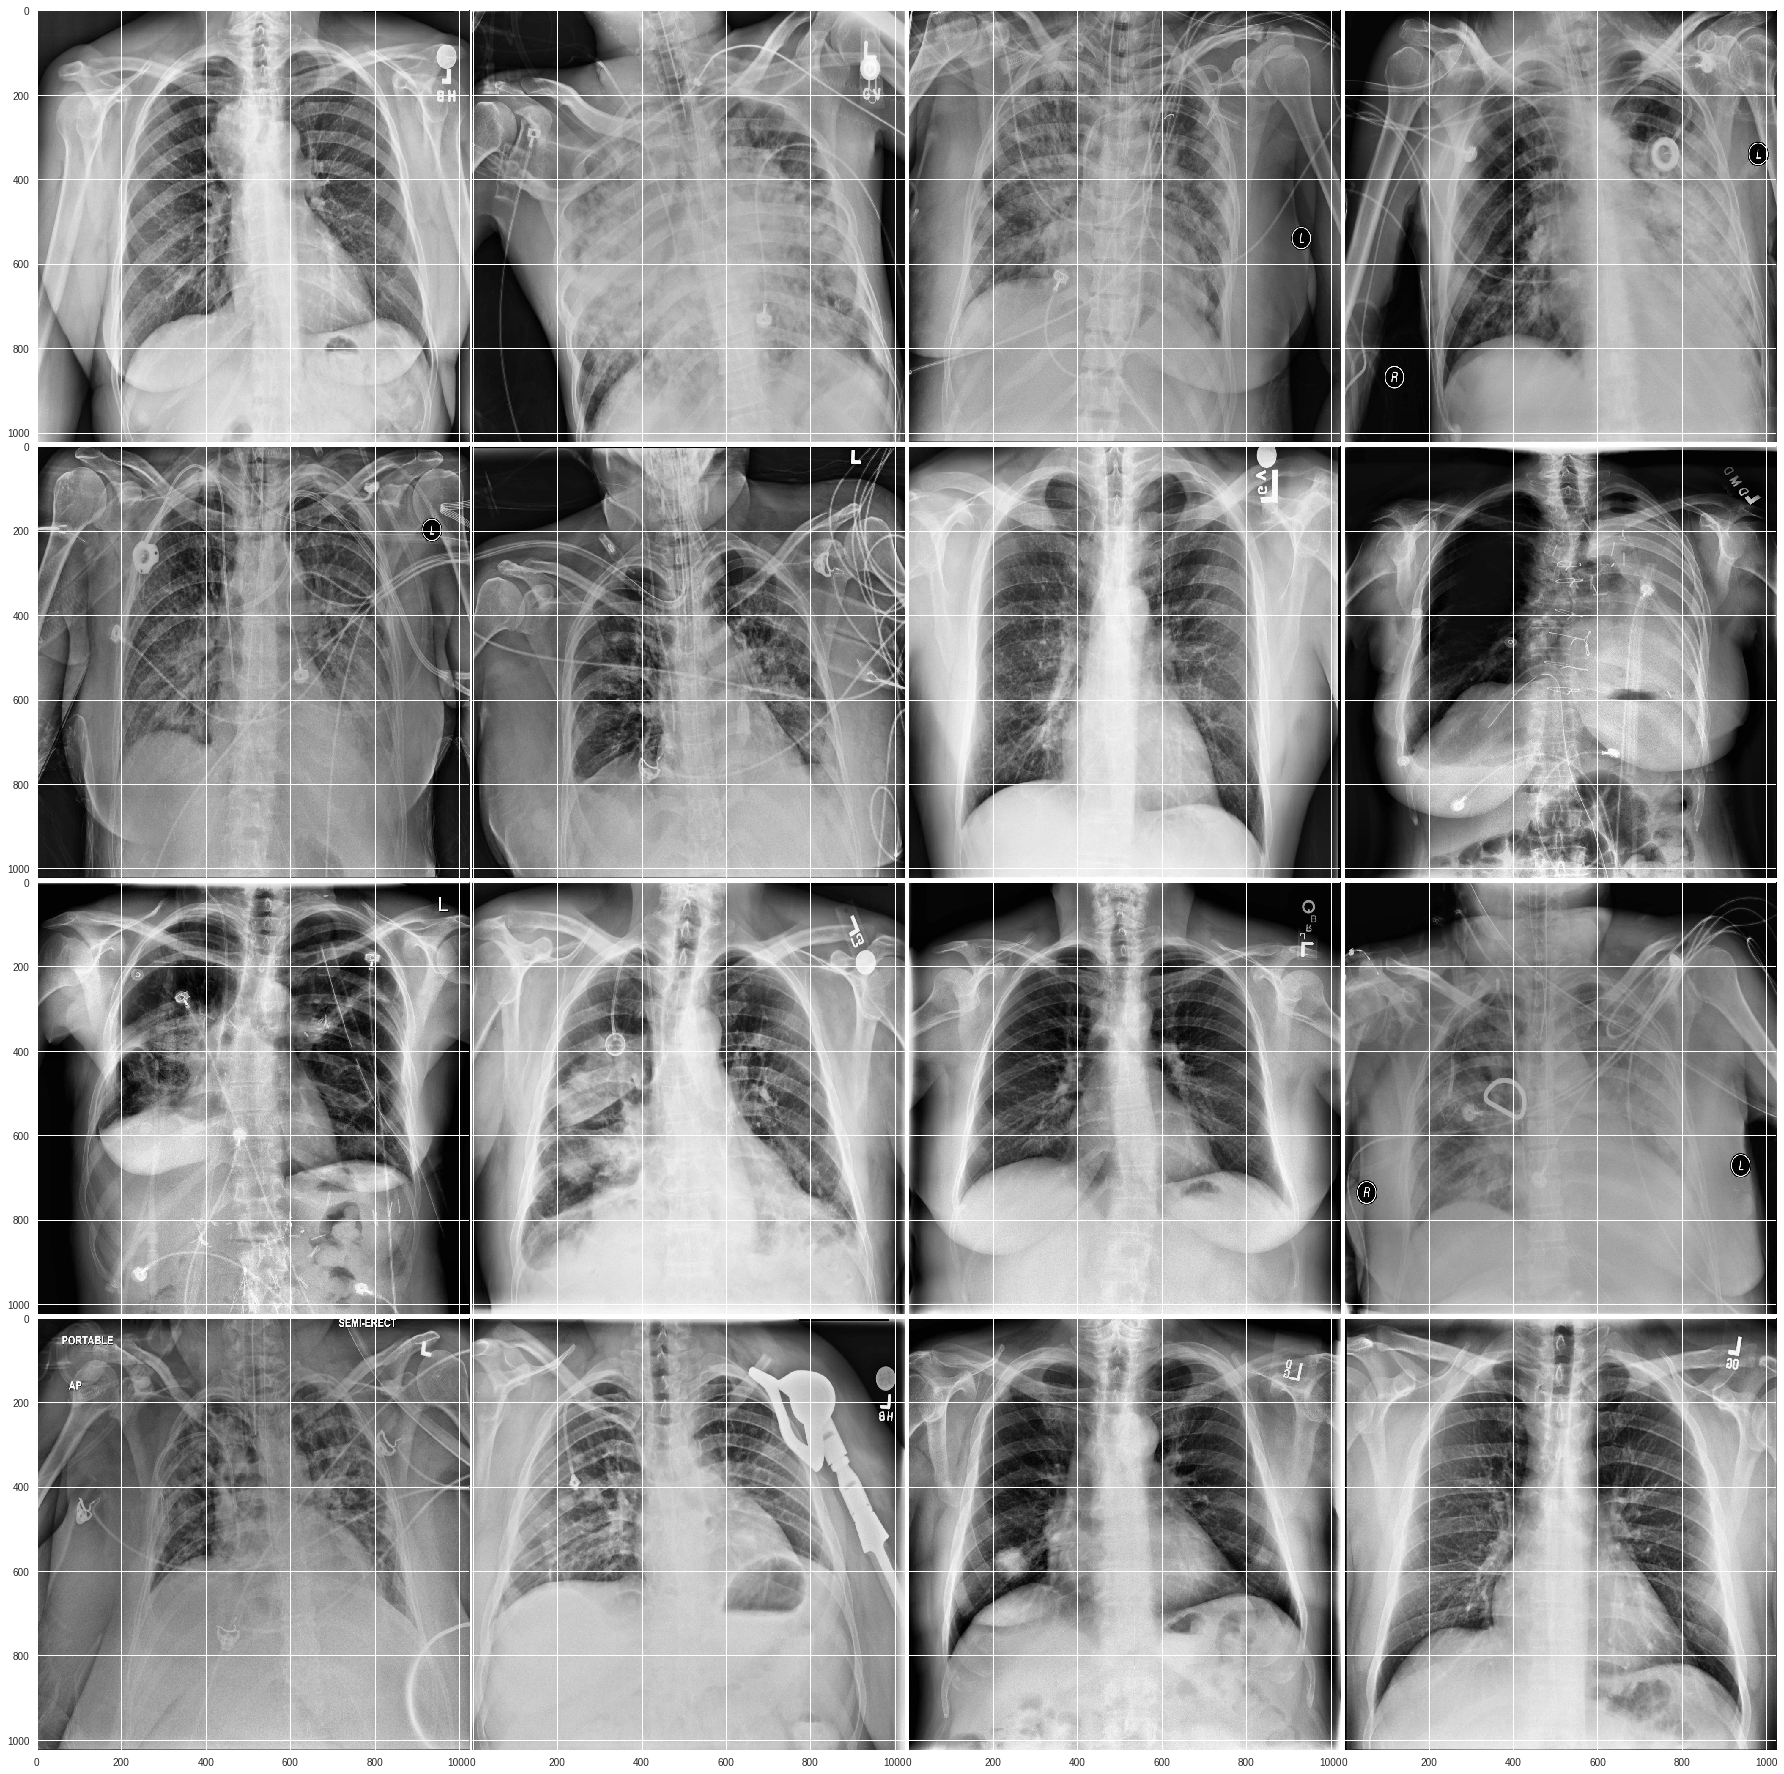

In [84]:
imgview, label = next(iter(transformed_valid_dl))
#print(img, label.size())
fig = plt.figure(1, figsize=(32, 32))
grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.05)  
for i in range(imgview.size()[0]):
  #print(img)
  ax = grid[i]
  print(imgview.shape)
  imshow(ax,imgview[i])
  print(label[i])

In [85]:
def get_count(layer_name,model_name):
  ct  = 0 
  layer_count ={}
  for name, child in model_name.named_children():
      for name2, params in child.named_parameters():
        layer_count[name2] = ct
        ct +=1
  return layer_count[layer_name]

def freeze_till(layer_name,model_name):
  ct  = 0 
  count = get_count(layer_name,model_name)
  
  for name, child in model_name.named_children():
    for name2, params in child.named_parameters():
      
      if ct > count :
          
            params.requires_grad = True
      else :
            params.requires_grad = False
      ct +=1

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

dataloaders = {"train": transformed_train_dl, "val": transformed_valid_dl}
dataset_sizes = {"train": len(transformed_train_dataset),"val":len(transformed_valid_dataset)}
print(dataset_sizes)

## This function evaluate the loss / optimize  and returns model and the weight of the epoch which has highest accuracy
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        # Each epoch has a training and validation phase
        # In train phase they are settting 2 variable in model class - train() and schedular  = step()
        # In Validation phase setting the model class - eval()
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.# phase - train or validation
            for inputs, labels in dataloaders[phase]:
                #inputs = np.transpose(inputs,(2,0,1))
                inputs = inputs.to(device)
                labels = labels.to(device)
                labels = labels.type(torch.cuda.LongTensor)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    
                    #print(outputs.shape)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                #print(phase,preds,labels.data)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            #print(preds[1:10],labels.data[1:10])
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        #print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

{'train': 23500, 'val': 963}


In [36]:
# # Load Pretrained model

# #model_ft = models.resnet18(pretrained=True)
# model_ft = models.densenet169(pretrained=True)

# # Freeze specific layers of the model

# freeze_till('transition2.conv.weight',model_ft)

# # num_ftrs = model_ft.fc.in_features # fc for resnet
# num_ftrs = model_ft.classifier.in_features
# model_ft.classifier = nn.Linear(num_ftrs, 2)
# model_ft = model_ft.to(device)

# criterion = nn.CrossEntropyLoss(weight = torch.tensor([1, 1.05]).type(torch.cuda.FloatTensor))

/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.torch/models/densenet169-b2777c0a.pth
100%|██████████| 57365526/57365526 [00:03<00:00, 16203222.43it/s]


In [0]:
# optimizer_ft = optim.Adam(list(filter(lambda p: p.requires_grad, model_ft.parameters())), lr = 1e-4, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)
# model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
#                        num_epochs=10)

In [0]:
# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
  def __init__(self, num_classes=2):
      super(ConvNet, self).__init__()
      self.conv1 = nn.Sequential(
          nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
          #nn.BatchNorm2d(16),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2))
      self.conv2 = nn.Sequential(
          nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
          #nn.BatchNorm2d(32),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2))
      self.conv3 = nn.Sequential(
              nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
              nn.BatchNorm2d(64),
              nn.ReLU(),
              nn.MaxPool2d(kernel_size=2, stride=2))
      self.conv4 = nn.Sequential(
              nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
              nn.BatchNorm2d(128),
              nn.ReLU(),
              nn.MaxPool2d(kernel_size=2, stride=2))
      self.conv5 = nn.Sequential(
              nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
              nn.BatchNorm2d(128),
              nn.ReLU(),
              nn.MaxPool2d(kernel_size=2, stride=2))
      self.conv6 = nn.Sequential(
              nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
              nn.BatchNorm2d(64),
              nn.ReLU(),
              nn.MaxPool2d(kernel_size=2, stride=2))

      self.fc1 = nn.Linear(16*16*64, 64)
      self.fc2 = nn.Linear(64, 2)

  def forward(self, x):
      out = self.conv1(x)
      out = self.conv2(out)
      out = self.conv3(out)
      out = self.conv4(out)
      out = self.conv5(out)
      out = self.conv6(out)
      out = out.reshape(out.size(0), -1)
      out = self.fc1(out)
      out = self.fc2(out)
      return out

In [0]:
my_model = ConvNet(2).to(device)

In [89]:
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(my_model.parameters(), lr = 1e-5, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.1)
model_ft = train_model(my_model, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------
train Loss: 0.3500 Acc: 0.8447
val Loss: 0.3491 Acc: 0.8390
Epoch 1/4
----------
train Loss: 0.3345 Acc: 0.8512
val Loss: 0.3544 Acc: 0.8359
Epoch 2/4
----------
train Loss: 0.3229 Acc: 0.8579
val Loss: 0.3737 Acc: 0.8297
Epoch 3/4
----------
train Loss: 0.3093 Acc: 0.8664
val Loss: 0.3612 Acc: 0.8349
Epoch 4/4
----------
train Loss: 0.3074 Acc: 0.8678
val Loss: 0.3622 Acc: 0.8359
Training complete in 193m 39s
Best val Acc: 0.839045
